In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from keras.models import load_model

# Cargar el modelo
model = load_model('model/model_vocales.keras')

# Diccionario para mapear índices a letras
index_to_letter = {0: 'A', 1: 'E', 2: 'I', 3: 'O', 4: 'U'}

# Iniciar la captura de video
cap = cv2.VideoCapture(1)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
cantidad_manos = 0

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

while True:
    data_aux = []
    x_ = []
    y_ = []

    ret, frame = cap.read()
    if not ret:
        break

    H, W, _ = frame.shape

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,  # image to draw
                hand_landmarks,  # model output
                mp_hands.HAND_CONNECTIONS,  # hand connections
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

        for hand_landmarks in results.multi_hand_landmarks:
            cantidad_manos = len(results.multi_hand_landmarks)
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y

                x_.append(x)
                y_.append(y)

            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x - min(x_))
                data_aux.append(y - min(y_))

        x1 = int(min(x_) * W) - 10
        y1 = int(min(y_) * H) - 10

        x2 = int(max(x_) * W) - 10
        y2 = int(max(y_) * H) - 10

        if cantidad_manos == 1:
            probabilities = model.predict(np.asarray([data_aux]))[0]

            if np.max(probabilities) > 0.8:
                prediction = np.argmax(probabilities)
                predicted_character = index_to_letter[prediction]
            else:
                predicted_character = "undetected"
        else:
            predicted_character = "forbidden"

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
        cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 0, 0), 3, cv2.LINE_AA)

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


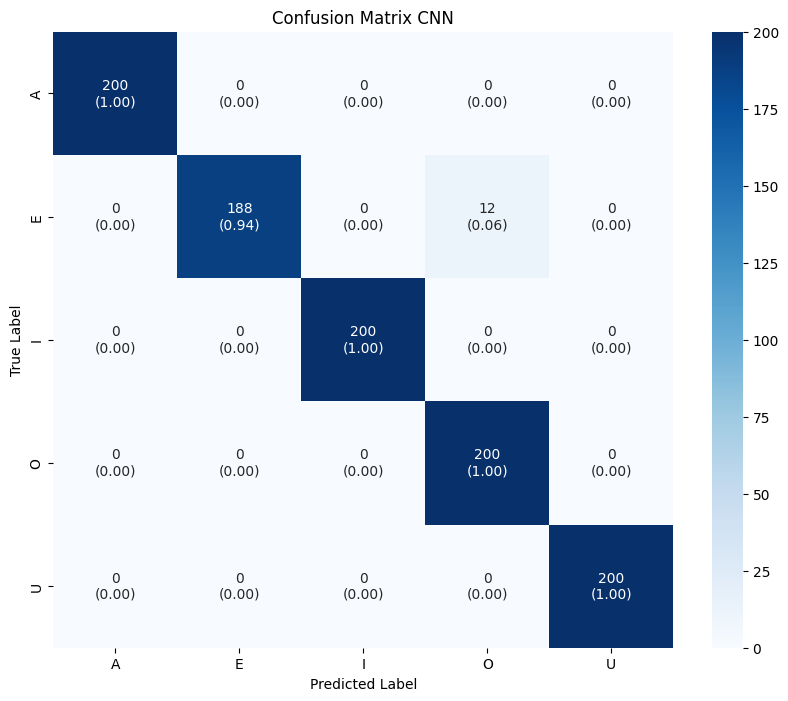

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       200
           E       1.00      0.94      0.97       200
           I       1.00      1.00      1.00       200
           O       0.94      1.00      0.97       200
           U       1.00      1.00      1.00       200

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [1]:
import pickle
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo guardado en formato .h5
model = load_model('model/model_vocales.keras')

# Diccionario para mapear índices a letras
index_to_letter = {0: 'A', 1: 'E', 2: 'I', 3: 'O', 4: 'U'}

# Cargar los datos de prueba desde el archivo .pickle
data_dict = pickle.load(open('data/data_vocales_test.pickle', 'rb'))

# Convertir los datos y etiquetas a arrays de numpy
data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

# Convertir etiquetas de texto a números usando LabelEncoder
label_encoder = LabelEncoder()
y_true_classes = label_encoder.fit_transform(labels)

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(data)

# Convertir predicciones a clases (etiquetas) si es necesario
if y_pred.ndim > 1 and y_pred.shape[1] > 1:
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_pred_classes = y_pred.astype(int)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix_normalized = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')

# Crear la matriz combinada
combined_matrix = np.zeros_like(conf_matrix, dtype=np.float32).astype(str)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        combined_matrix[i, j] = f"{conf_matrix[i, j]}\n({conf_matrix_normalized[i, j]:.2f})"

# Configuración de la visualización de la matriz combinada
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=combined_matrix, fmt='', cmap='Blues', xticklabels=['A', 'E', 'I', 'O', 'U'], yticklabels=['A', 'E', 'I', 'O', 'U'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix CNN')
plt.show()

# Reporte de Clasificación
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['A', 'E', 'I', 'O', 'U']))